In [1]:
from pathlib import Path

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import h5py
import glob

from lhcsmapi.Time import Time

ModuleNotFoundError: No module named 'lhcsmapi'

In [2]:
Time.to_unix_timestamp('2014-01-01 00:00:00+01:00'), Time.to_unix_timestamp('2023-01-01 00:00:00+01:00')

(1388530800000000000, 1672527600000000000)

In [5]:
hdf_dir = Path('/eos/project/m/ml-for-alarm-system/private/RB_signals/data_1')
failed_dir = Path('/eos/project/m/ml-for-alarm-system/private/RB_signals/failed_1')
context_path = Path('/eos/project/m/ml-for-alarm-system/private/RB_signals/context_1')

In [6]:
mp3_fpa_df = pd.read_csv("../data/RB_TC_extract_2021_11_22_processed.csv")

In [7]:
files = sorted(glob.glob(str(context_path / "*.csv")))
df_context = pd.concat(map(pd.read_csv, files))
df_context["timestamp_fgc_datetime"] = df_context.timestamp_fgc.apply(Time.to_datetime)
df_context.reset_index(drop=True, inplace=True)

NameError: name 'Time' is not defined

In [ ]:
files = sorted(glob.glob(str(failed_dir / "*.csv")))
df_failed = pd.concat(map(pd.read_csv, files))
df_failed["timestamp_fgc_datetime"] = df_failed.timestamp_fgc.apply(Time.to_datetime)
df_failed.reset_index(drop=True, inplace=True)

# Missing events I_MEAS 

In [4]:
df_IMEAS = df_context[~df_context['PCPM_STATUS.I_MEAS'].isna()][["circuit_name", "timestamp_fgc", "timestamp_fgc_datetime",'PCPM_STATUS.I_MEAS']]
df_IMEAS

NameError: name 'df_context' is not defined

# Missing events U_DIODE NXCALS

In [7]:
# find distinct key
df_diode = df_context.filter(regex="DIODE")
print(len(df_diode.columns))

columns = df_diode.columns.values
unique_signals = [c.split("_")[0] for c in columns]
list(dict.fromkeys(unique_signals))

2444


['VoltageNXCALS', 'VoltageNQPS']

In [8]:
valid_udiode_nxcals_index = df_context.filter(regex="VoltageNXCALS.*U_DIODE").dropna(how='all').index.values
df_context_valid = df_context.iloc[valid_udiode_nxcals_index][["circuit_name", "timestamp_fgc", "timestamp_fgc_datetime"]]
df_context_valid

,circuit_name,timestamp_fgc,timestamp_fgc_datetime
0,RB.A12,1418330714580000000,2014-12-11 21:45:14.580000+01:00
1,RB.A12,1418384764500000000,2014-12-12 12:46:04.500000+01:00
2,RB.A12,1418484670560000000,2014-12-13 16:31:10.560000+01:00
3,RB.A12,1418538814280000000,2014-12-14 07:33:34.280000+01:00
4,RB.A12,1418560853860000000,2014-12-14 13:40:53.860000+01:00
...,...,...,...
823,RB.A81,1629782243260000000,2021-08-24 07:17:23.260000+02:00
824,RB.A81,1629831279760000000,2021-08-24 20:54:39.760000+02:00
825,RB.A81,1629911725660000000,2021-08-25 19:15:25.660000+02:00
826,RB.A81,1629956195440000000,2021-08-26 07:36:35.440000+02:00


# Missing events U_DIODE PM

In [9]:
valid_udiode_pm_index = df_context.filter(regex="VoltageNQPS").dropna(how='all').index.values
df_context_valid = df_context.iloc[valid_udiode_pm_index][["circuit_name", "timestamp_fgc", "timestamp_fgc_datetime"]]
df_context_valid

,circuit_name,timestamp_fgc,timestamp_fgc_datetime
9,RB.A12,1446531949860000000,2015-11-03 07:25:49.860000+01:00
10,RB.A12,1465578785320000000,2016-06-10 19:13:05.320000+02:00
11,RB.A12,1470229204900000000,2016-08-03 15:00:04.900000+02:00
12,RB.A12,1492890506140000000,2017-04-22 21:48:26.140000+02:00
13,RB.A12,1492946941100000000,2017-04-23 13:29:01.100000+02:00
...,...,...,...
823,RB.A81,1629782243260000000,2021-08-24 07:17:23.260000+02:00
824,RB.A81,1629831279760000000,2021-08-24 20:54:39.760000+02:00
825,RB.A81,1629911725660000000,2021-08-25 19:15:25.660000+02:00
826,RB.A81,1629956195440000000,2021-08-26 07:36:35.440000+02:00


In [10]:
df_context[~df_context.index.isin(valid_udiode_pm_index)][["circuit_name", "timestamp_fgc", "timestamp_fgc_datetime"]]#.to_csv("missing_U_DIODE_PM.csv")

,circuit_name,timestamp_fgc,timestamp_fgc_datetime
0,RB.A12,1418330714580000000,2014-12-11 21:45:14.580000+01:00
1,RB.A12,1418384764500000000,2014-12-12 12:46:04.500000+01:00
2,RB.A12,1418484670560000000,2014-12-13 16:31:10.560000+01:00
3,RB.A12,1418538814280000000,2014-12-14 07:33:34.280000+01:00
4,RB.A12,1418560853860000000,2014-12-14 13:40:53.860000+01:00
...,...,...,...
764,RB.A81,1424375721660000000,2015-02-19 20:55:21.660000+01:00
765,RB.A81,1424417596920000000,2015-02-20 08:33:16.920000+01:00
766,RB.A81,1424465417880000000,2015-02-20 21:50:17.880000+01:00
767,RB.A81,1424501293480000000,2015-02-21 07:48:13.480000+01:00


In [50]:
signal_name = "VoltageNQPS_MB.C25L1:U_DIODE_RB"
df_context.iloc[df_context.filter(regex=signal_name).dropna(how='all').index.values][["circuit_name", "timestamp_fgc", "timestamp_fgc_datetime",signal_name]]

,circuit_name,timestamp_fgc,timestamp_fgc_datetime,VoltageNQPS_MB.C25L1:U_DIODE_RB
810,RB.A81,1628794110760000000,2021-08-12 20:48:30.760000+02:00,2267.0
811,RB.A81,1628838059560000000,2021-08-13 09:00:59.560000+02:00,3600.0
812,RB.A81,1628882955080000000,2021-08-13 21:29:15.080000+02:00,3600.0


In [54]:
df_context[df_context.timestamp_fgc == 1446531949860000000].dropna(axis=1)

,circuit_type,circuit_name,timestamp_fgc,PCPM_STATUS.I_MEAS,PCPM_IAB.I_A,PCPM_IEARTH.IEARTH,PCPM_STATUS.I_EARTH_PCNT,PCPM_STATUS.I_REF,VoltageNXCALS_MB.A8R1:U_DIODE_RB,VoltageNXCALS_MB.B8R1:U_DIODE_RB,...,VoltageNXCALS_MB.A8L2:U_EARTH_RB,VoltageNQPS_MB.C33L2:U_DIODE_RB,VoltageNQPS_MB.A33L2:U_DIODE_RB,VoltageNQPS_MB.B32L2:U_DIODE_RB,VoltageNQPS_DQQDS.B33L2.RB.A12:U_REF_N1,VoltageNQPS_MB.B33L2:U_DIODE_RB,VoltageNQPS_MB.C32L2:U_DIODE_RB,VoltageNQPS_MB.A32L2:U_DIODE_RB,VoltageNQPS_DQQDS.B32L2.RB.A12:U_REF_N1,timestamp_fgc_datetime
9,RB,RB.A12,1446531949860000000,21000.0,8192.0,1024.0,21000.0,21000.0,5500.0,5500.0,...,687.0,3600.0,3600.0,3600.0,3600.0,3600.0,3600.0,3600.0,3600.0,2015-11-03 07:25:49.860000+01:00


## Open h5 files

In [2]:
file_dir = Path('/eos/project/m/ml-for-alarm-system/private/RB_signals/data')

for index, row in df_context.iterrows():   
    circuit_type = 'RB' #row['circuit_type']
    circuit_name = 'RB.A12' #row['circuit_name']
    timestamp_fgc = 1619196160600000000 #row['timestamp_fgc']
    
    filename = f"{circuit_type}_{circuit_name}_{timestamp_fgc}.hdf5"
    
    with h5py.File(file_dir / filename, "r") as f:
        
        k = np.array(f.keys())
        print(k)

        #plt.plot(np.array(f["VoltageNXCALS"]["MB.A31L2:U_DIODE_RB"].get("values")))
        
    break

NameError: name 'df_context' is not defined

In [8]:
import matplotlib.pyplot as plt

In [18]:
np.array([1,2,3])*2

array([2, 4, 6])

In [32]:
def fun(x):
    plt.plot(np.array([1,2,3])*x)


Text(0.5, 0.98, 'Main title')

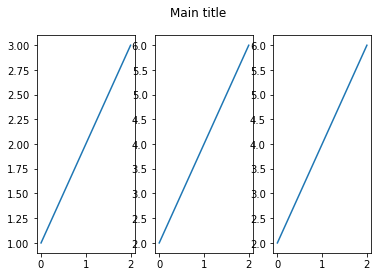

In [36]:
fig = plt.figure()
fig.add_subplot(1, 3, 1)
fun(1)
fig.add_subplot(1, 3, 2)
fun(2)
fig.add_subplot(1, 3, 3)
fun(2)

fig.suptitle('Main title')

In [35]:
k = "baby"
k.contain("by")

AttributeError: 'str' object has no attribute 'contain'